In [1]:
import pennylane as qml
import time
from pennylane import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import collections
import tensorflow as tf

In [2]:
tf.config.set_visible_devices([], 'GPU')
tf.keras.backend.set_floatx('float64')

In [3]:
n_train = 5000
n_test  = 1000
num_qubits = 4

In [4]:
dev = qml.device('lightning.qubit', wires=4)

@qml.qnode(dev,interface="autograd", diff_method="parameter-shift")
def circuit(inputs, weights):
    # Encoding of 4 classical input values
    for j in range(num_qubits):
        qml.RY(np.pi * inputs[j], wires=j)
    
    qml.RY(weights[0], wires=[3])
    qml.Hadamard(wires=[1])
    qml.S(wires=[1])
    qml.RX(weights[1], wires=[0])
    qml.RZ(weights[2], wires=[0])
    qml.RY(weights[3], wires=[2])

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(num_qubits)]

In [5]:
def QNN():
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=3e-4) 
    
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

Counter({0: 500, 1: 500, 2: 500, 3: 500, 4: 500, 5: 500, 6: 500, 7: 500, 8: 500, 9: 500})


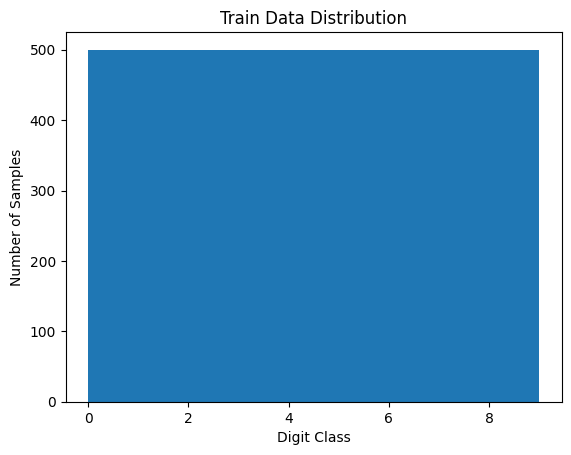

Counter({0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100, 6: 100, 7: 100, 8: 100, 9: 100})


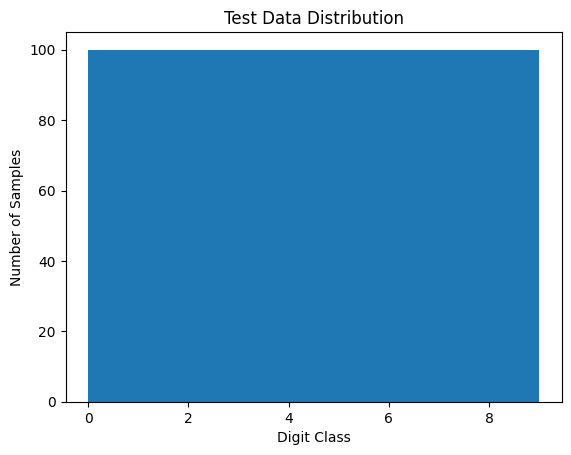

In [6]:
def load_dataset(train_size, test_size):
    mnist_dataset = keras.datasets.mnist
    (train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

    # --- Train Set ---
    train_idx_by_class = [np.where(train_labels == i)[0] for i in range(10)]  
    train_idx_selected = [
        np.random.choice(idxs, min(len(idxs), train_size // 10), replace=False)  # Adjusted for train_size
        for idxs in train_idx_by_class
    ]
    train_idx_selected = np.concatenate(train_idx_selected) 

    train_images = train_images[train_idx_selected]
    train_labels = train_labels[train_idx_selected]

    # --- Test Set --- (Apply the same logic)
    test_idx_by_class = [np.where(test_labels == i)[0] for i in range(10)] 
    test_idx_selected = [
        np.random.choice(idxs, min(len(idxs), test_size // 10), replace=False)  # Adjusted for test_size
        for idxs in test_idx_by_class
    ]
    test_idx_selected = np.concatenate(test_idx_selected) 

    test_images = test_images[test_idx_selected]
    test_labels = test_labels[test_idx_selected]

    # Normalize pixel values within 0 and 1
    train_images = train_images / 255.0
    test_images = test_images / 255.0

    # Add extra dimension for convolution channels
    train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
    test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)
    
    #new_height = 14  # 28 / 2
    #new_width = 14  # 28 / 2 
    #train_images = tf.image.resize(train_images, (new_height, new_width))
    #test_images = tf.image.resize(test_images, (new_height, new_width))
    
    return train_images, train_labels, test_images, test_labels

train_images, train_labels, test_images, test_labels = load_dataset(n_train, n_test)

label_counts = collections.Counter(train_labels)
print(label_counts)

plt.hist(train_labels)
plt.xlabel('Digit Class')
plt.ylabel('Number of Samples')
plt.title('Train Data Distribution')
plt.show()
label_counts = collections.Counter(test_labels)
print(label_counts)

plt.hist(test_labels)
plt.xlabel('Digit Class')
plt.ylabel('Number of Samples')
plt.title('Test Data Distribution')
plt.show()

/var/folders/vw/hv55q7kn1vl9cm96jf24vpkh0000gn/T/ipykernel_7326/982544360.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


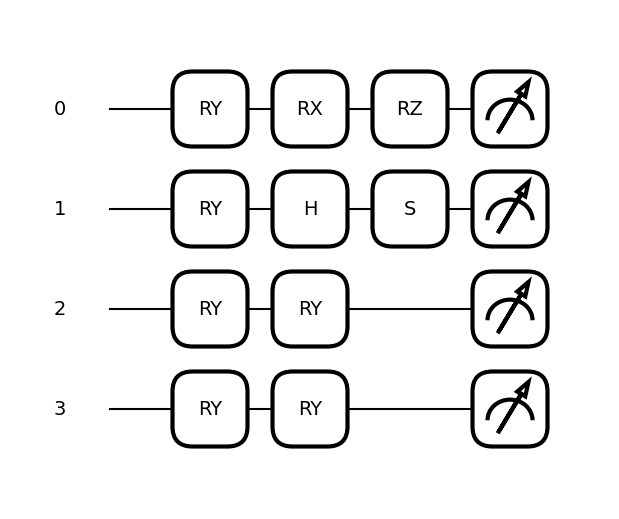

In [7]:
qlayer = qml.qnn.KerasLayer(circuit, {"weights": (4,)}, output_dim=4)
fig, ax = qml.draw_mpl(circuit)([1.0,4,54,44], [1,2,3,4,5])
fig.show()

In [8]:
def extract_windows(image):
    height, width, num_channels = image.shape  # Get image dimensions

    # Reshape to extract all 2x2 windows
    windows = tf.reshape(image, (height // 2, width // 2, 2, 2, num_channels))
    windows = tf.transpose(windows, (0, 2, 1, 3, 4)) 

    # Batching reshape
    windows = tf.reshape(windows, ((height // 2) * (width // 2), 4, num_channels))

    return windows

def extract_all_patches(images):
    patches = tf.image.extract_patches(
        images=images,
        sizes=[1, 2, 2, 1],
        strides=[1, 2, 2, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
    )
    
    return patches

In [9]:
class HQNNQuanv(tf.keras.Model):
    def __init__(self):
        super(HQNNQuanv, self).__init__()
        self.quanv = qml.qnn.KerasLayer(circuit, {"weights": (4,)}, output_dim=4)
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(10, activation="softmax")
        
    def call(self, inputs):
        num_samples, height, width, num_channels = inputs.shape
        patches = extract_all_patches(inputs)
        
        batch_patches = patches
        batch_patches = tf.reshape(batch_patches, [-1,4])
            
        quanvoluted_patches = tf.stack([self.quanv(patch) for patch in batch_patches])            
        quanvoluted_patches = tf.reshape(quanvoluted_patches, [num_samples, 14, 14, 4])
        
        out = quanvoluted_patches
        
        """for sample in range(num_samples):
            windows = extract_windows(inputs[sample])
            
            for idx, window in enumerate(windows):
                window = tf.reshape(window, (4,))
                q_result = self.quanv(window)
                
                ix = idx % 28
                iy = idx // 28
                
                for j in range(4):
                    indices.append([sample, ix // 2, iy // 2, j])
                    updates.append(q_result[j])"""
        
        #out = tf.tensor_scatter_nd_update(out, indices, updates)
        out = self.flatten(out)
        out = self.dense(out)
        return out

In [10]:
test = extract_all_patches(test_images)

In [11]:
print(test.shape)

(1000, 14, 14, 4)


In [12]:
model = HQNNQuanv()
print(f"model_output_shape: {model(test_images).shape}")
model.summary()

model_output_shape: (1000, 10)
Model: "hqnn_quanv"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  multiple                  4         
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  7850      
                                                                 
Total params: 7854 (61.36 KB)
Trainable params: 7854 (61.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return 3e-4

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=3e-3)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

r = model.fit(train_images, train_labels, epochs=30, validation_data=(test_images, test_labels), batch_size = 512, callbacks=[lr_callback]) 

Epoch 1/30
10/10 [==============================] - 7825s 785s/step - loss: 1.9487 - accuracy: 0.3698 - val_loss: 1.2094 - val_accuracy: 0.6470 - lr: 0.0030
Epoch 2/30
10/10 [==============================] - 6624s 667s/step - loss: 0.9959 - accuracy: 0.7236 - val_loss: 0.7608 - val_accuracy: 0.7820 - lr: 0.0030
Epoch 3/30
10/10 [==============================] - 6604s 665s/step - loss: 0.6989 - accuracy: 0.8018 - val_loss: 0.5905 - val_accuracy: 0.8430 - lr: 0.0030
Epoch 4/30
10/10 [==============================] - 6602s 665s/step - loss: 0.5696 - accuracy: 0.8356 - val_loss: 0.5163 - val_accuracy: 0.8650 - lr: 0.0030
Epoch 5/30
 7/10 [====================>.........] - ETA: 32:30 - loss: 0.5075 - accuracy: 0.8513